# SALARY PREDICTION FROM EMAIL NETWORK

**Note: networxk=1.11**

## INTRODUCTION

In this data science project I combine **network analysis** and **supervised machine learning** to predict given an email network of a company, what employees are receiving a management position salary.

**The email network of the company can be represented as a graph** and it is defined as follows:
* Each node corresponds to a person at the company.
* Each edge indicates that at least one email has been sent between two people.
* The network contains the node attributes *Department* and *ManagementSalary*.
* *Department* indicates the department in the company which the person belongs to, and *ManagementSalary* indicates whether that person is receiving a management position salary (1) or if not (0).

The problem we face is that there are missing values for the attribute *ManagementSalary*. **Our goal will be to predict these values.**

The steps we are going to follow are:

1. Get the data.
2. Explore the data.
3. Prepare de data.
4. Feature selection.
5. Short-List Promissing Models.
6. Fine-Tune the system.
7. Reach a conclusion.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
sns.set()
%matplotlib inline

## 1. GETTING THE DATA

The first step is to analyse the network in order to get more information about the company.

We have all the information in a networkx graph. NetworkX is a Python language software package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks.

In [2]:
file = 'data/email_prediction.txt'
G = nx.read_gpickle(file)
G

## 2. EXPLORING THE DATA (EDA)

If we try to draw the graph we can see it's very messy, you can hardly see anything. Each blue dot represents a node and therefore an employee, and an edge between two nodes means that those employees have been in contact through email.

/media/agm/D228FA0328F9E67F/github_repos/email_network/conda_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/media/agm/D228FA0328F9E67F/github_repos/email_network/conda_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/media/agm/D228FA0328F9E67F/github_repos/email_network/conda_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/media/agm/D228FA0328F9E67F/github_repos/email_network/conda_env/lib/python3.7/site-packages/networkx/drawing/nx_py

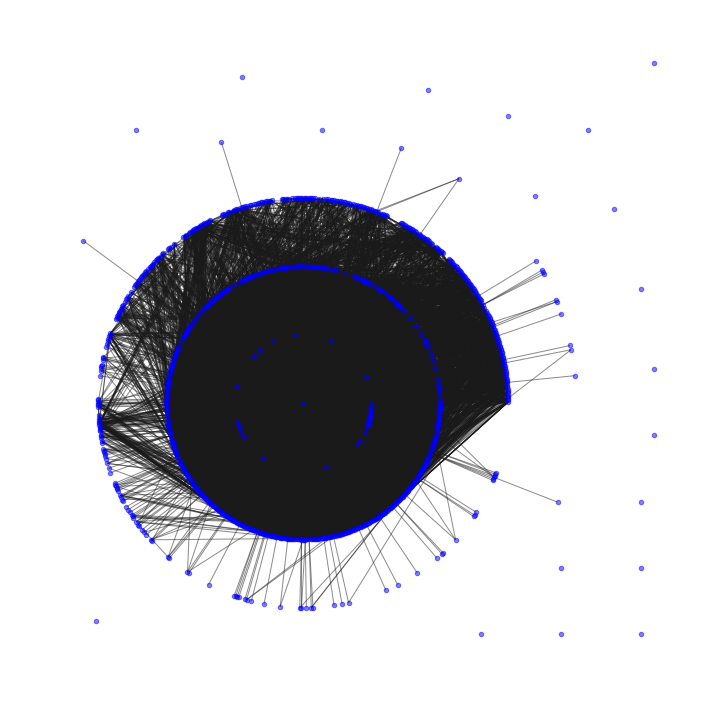

In [3]:
pos = graphviz_layout(G, prog='twopi')

fig, ax = plt.subplots(1, 1, figsize = (10,10))
nx.draw(G, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis('equal')
plt.tight_layout()

Let's see if we can extract some information from the graph:

- How many employees have used the email in the company?
- How many employees in the company have been in contact through email?

Answer those questions is as easy as get the number of nodes and the number of edges of the graph.

In [4]:
print('{} employees have used the email and {} employees have been in contact.'.format(len(G.nodes()),len(G.edges())))

1005 employees have used the email and 16706 employees have been in contact.


In [5]:
avg_contact = len(G.edges())/len(G.nodes())
print('We can deduce from that information, that on average, each employee have been in contact with {:.1f} coworkers.'.format(avg_contact))

We can deduce from that information, that on average, each employee have been in contact with 16.6 coworkers.


We can also convert the graph to a pandas dataframe. The row and column index is the number of employee and the dataframe entries are equal to 1 if exist a connection between the employee i and the employe j and equal to 0 otherwise. Therefore the dataframe is symmetrical.

In [6]:
nx.to_pandas_dataframe(G)

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,1000,1001,1002,1003,1004
0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The graph has more information. Each node has two attributes, the department where they work and if they are receiving a management salary or not.

In [7]:
G.nodes(data = True)[:10]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (7, {'Department': 14, 'ManagementSalary': 0.0}),
 (8, {'Department': 14, 'ManagementSalary': nan}),
 (9, {'Department': 14, 'ManagementSalary': 0.0})]

We see how there are employees with missing values in the attribute *Management Salary*. **Remember our is goal is to predict those nan values.**

Now we store that information in a data frame, where each column is an attribute and the index is the number of the employee:

In [8]:
df = pd.DataFrame(index = G.nodes())
df['department'] = pd.Series(nx.get_node_attributes(G,'Department'))
df['management_salary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df.head()

,department,management_salary
0,1,0.0
1,1,NaN
2,21,NaN
3,21,1.0
4,21,1.0


In [9]:
df.shape

(1005, 2)

We check for nan values:

In [10]:
df.isna().sum()

department             0
management_salary    252
dtype: int64

Now we are able to answer more questions:

* How many departments does the company have?
* Which is the department with the most employees?

In [11]:
print('The company has {} departments and the department with most employees is number {} with {} employees.'
      .format(df['department'].nunique(), df['department'].value_counts().idxmax(), df['department'].value_counts().iloc[0]))

The company has 42 departments and the department with most employees is number 4 with 109 employees.


* How many employees are receiving a management salary?

In [12]:
df['management_salary'].value_counts()

0.0    634
1.0    119
Name: management_salary, dtype: int64

* What are the departments with the most employees ?

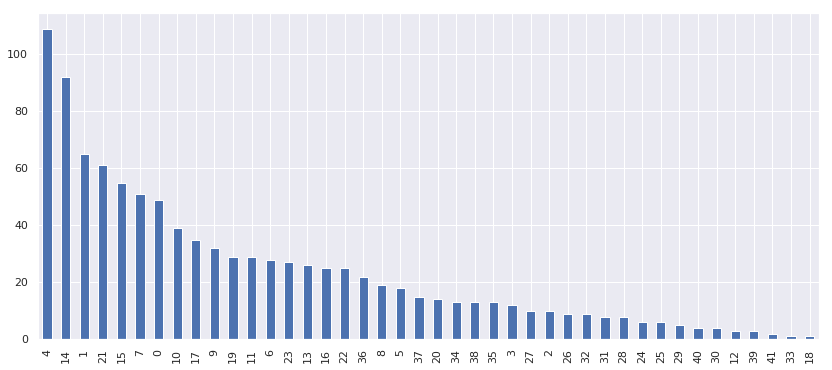

In [13]:
df['department'].value_counts().plot(kind='bar', figsize=(14,6))
plt.show()

* What are the 5 departments with the most employees receiving a management salary?

In [14]:
df.groupby('department').management_salary.sum().sort_values(ascending=False).head(5)

department
4     14.0
10    13.0
21    10.0
36     9.0
15     7.0
Name: management_salary, dtype: float64

### 2.1 DEFINING THE STRATEGY

Once we already know more about the company, we can focus on the goal of predict which employees are receiving a management position salary. In order to achieve it we will make the following realistic assumption:

**'*An employee with a management position salary is going to be somebody whose 'importance' in the network is higher than somebody who doesn't have that management position salary.*'**

Usually somebody with a magement position in a company is in charge of other employees and therefore sends or receive more emails. In addition she/he is in contact with other departments. This makes it more important within the network.

Actually, there are different ways to evaluate the importance of a node in a network, we will take into consideration the following ones with their definitions:
* **Degree**. Important nodes have many connections. It is defined as the number of edges adjacent to the node.
* **Closeness**. Important nodes are close to other nodes.
* **Betweenness**. Important node connect other nodes. 
* **Page Rank**. Important nodes are those with many in-links from important pages (developed by Google founders).
* **Clustering**. Important nodes have a higher fraction of pairs of the node's friends that are friends with each other.

We compute those values for all the employees (nodes) of the network (graph) and we add it to the previous dataframe:

In [15]:
df['degree'] = pd.Series(nx.degree_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized = True))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G, normalized = True, endpoints = False))
df['page_rank'] = pd.Series(nx.pagerank(G, alpha = 0.8))
df['clustering'] = pd.Series(nx.clustering(G))
df.head()

,department,management_salary,degree,closeness,betweenness,page_rank,clustering
0,1,0.0,0.043825,0.421991,0.001124,0.001202,0.276423
1,1,NaN,0.051793,0.422360,0.001195,0.001395,0.265306
2,21,NaN,0.094622,0.461490,0.006570,0.002531,0.297803
3,21,1.0,0.070717,0.441663,0.001654,0.001759,0.384910
4,21,1.0,0.095618,0.462152,0.005547,0.002424,0.318691


We check the distributions of the new variables:

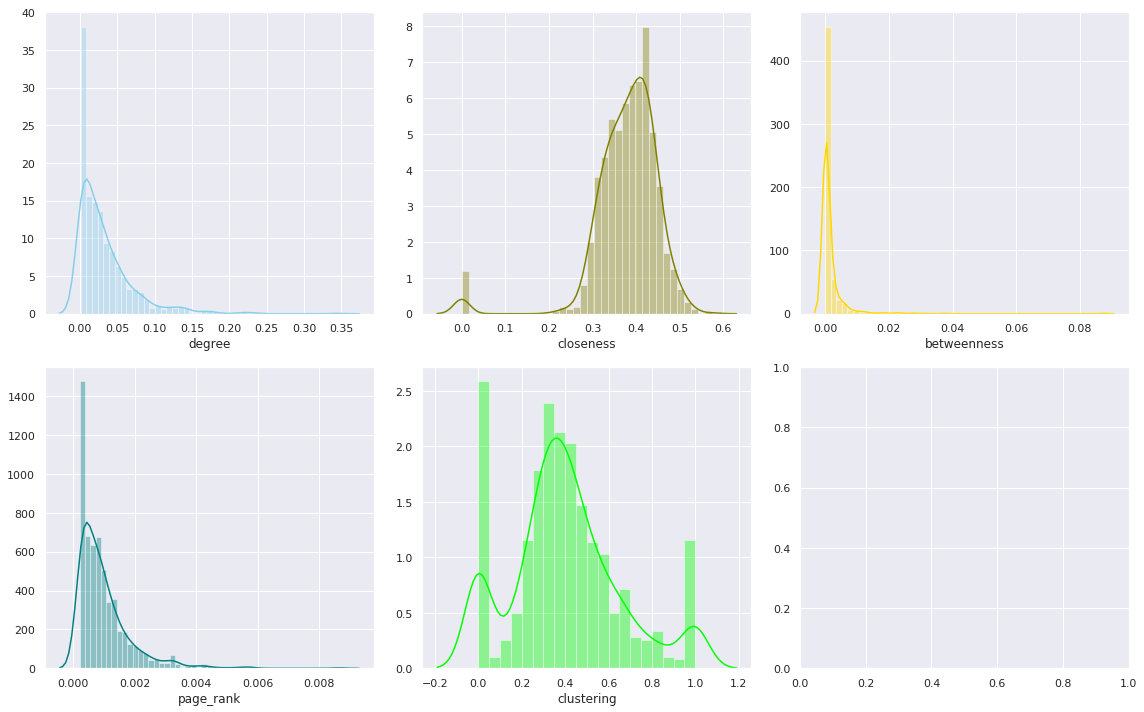

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
sns.distplot( df["degree"] , color="skyblue", ax=ax[0, 0])
sns.distplot( df["closeness"] , color="olive", ax=ax[0, 1])
sns.distplot( df["betweenness"] , color="gold", ax=ax[0, 2])
sns.distplot( df["page_rank"] , color="teal", ax=ax[1, 0])
sns.distplot( df["clustering"] , color="lime", ax=ax[1, 1])
plt.tight_layout()

*Closeness* and *clustering* are the only variables that seem to fit approximately a normal distribution dispite some values around 0 and in the case of *clustering* a high extreme value. The variables *degree*, *betweenness* and *page_rank* have **positive skewness**.

## 3. PREPARING THE DATA

At this stage is recommendable to create a test set, before exploring the relationships between variables. Our brain is an amazing pattern detection system, which means that is highly prone to overfitting. If we look at the test set, we may find some apparently interesting pattern that leads to select a particular kind of ML model.

In *df_data* we store the data we are going to use to train and test the model and in df_predict we store the employees we have to predict their attribute management_salary. (We can see how the column management_salary in df_predict have all nan).

In [17]:
df_data = df[~ np.isnan(df.management_salary)]
df_predict = df[np.isnan(df.management_salary)]
display(df_data.head())
display(df_predict.head())

,department,management_salary,degree,closeness,betweenness,page_rank,clustering
0,1,0.0,0.043825,0.421991,0.001124,0.001202,0.276423
3,21,1.0,0.070717,0.441663,0.001654,0.001759,0.384910
4,21,1.0,0.095618,0.462152,0.005547,0.002424,0.318691
6,25,1.0,0.114542,0.475805,0.012387,0.003045,0.155183
7,14,0.0,0.071713,0.420156,0.002818,0.001948,0.287785


,department,management_salary,degree,closeness,betweenness,page_rank,clustering
1,1,NaN,0.051793,0.422360,0.001195,0.001395,0.265306
2,21,NaN,0.094622,0.461490,0.006570,0.002531,0.297803
5,25,NaN,0.170319,0.501484,0.030995,0.004802,0.107002
8,14,NaN,0.036853,0.413151,0.000557,0.001048,0.447059
14,4,NaN,0.079681,0.442068,0.003726,0.002091,0.215784


Now we divide *df_data* in train set and test set; and we drop the column *management_salary* from *df_predict*:

In [18]:
X_data = df_data.drop(columns = ['management_salary'])
y_data = df_data['management_salary'] 
X_predict = df_predict.drop(columns = ['management_salary'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_predict.shape

((564, 6), (189, 6), (564,), (189,), (252, 6))

## 4. FEATURE SELECTION

The **correlation matrix** indicates if there is a linear correlation or dependence between the variables in the model, wether causal or not. So if there is a non-linear relationship between the variables, the coefficient will not be able to capture it.

In [19]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,department,degree,closeness,betweenness,page_rank,clustering,management_salary
257,0,0.018924,0.377632,0.000092,0.000655,0.450292,0.0
281,21,0.060757,0.439454,0.000903,0.001510,0.460549,1.0
526,4,0.062749,0.446768,0.002428,0.001683,0.307104,0.0
438,13,0.083665,0.450098,0.002794,0.002025,0.295694,0.0
461,17,0.025896,0.372824,0.000264,0.000856,0.568841,0.0


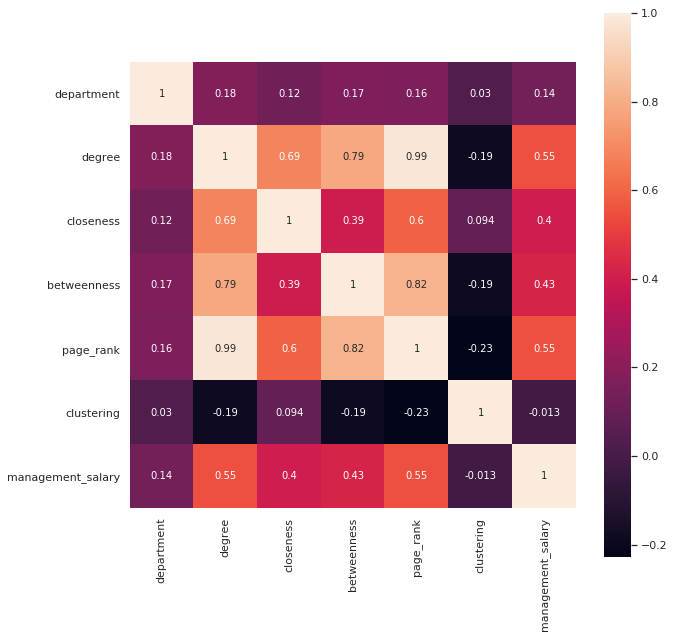

In [20]:
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, square=True, annot=True, ax=ax)
plt.show()

It is important to look at the variables related to the target variable (*management_salary*), since these variables will have higher predictive power and will make the model work better. However, the relationships between the rest of the variables should not be neglected, since introducing highly correlated variables into the model does not provide any benefit, it could even prejudice the results.

With this premise in mind, from the results above, we can see **the target variable has a higher correlation with degree, page_rank, betweenness and closeness** in that order. There are **explanatory variables with a high correlation**, for example between *degree* and *page_rank*. Therefore we must be careful to avoid **multicollinearity.**

We make scatterplots between all the variables and grouping by *management_salary* in order to see if there is some hidden relationship that the correlation coefficient has not been able to capture

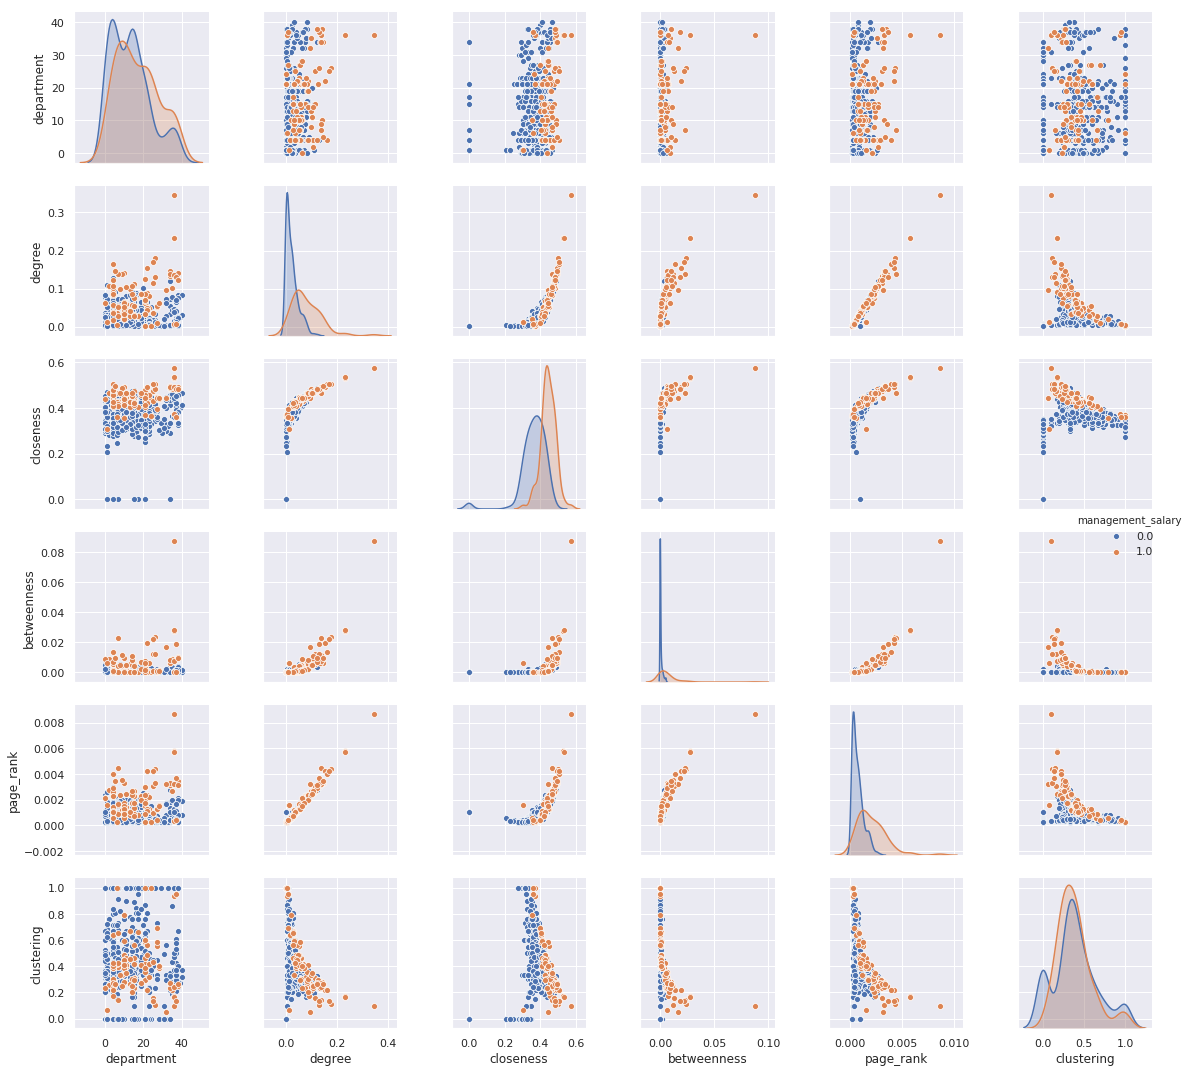

In [21]:
sns.pairplot(df_train, hue='management_salary')
plt.tight_layout()

From the results above, looking at the distributions of the variables, we confirm our assumption that employees with a management_salary (in orange) have a higher degree and closeness.

## 5. SHORT-LISTING PROMISSING MODELS

Within the scope of machine learning this is a **supervised learning classification task**. A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. In our case, we classify employees according to wether they are receiving a management salary or not.

In this section we are going to train many quick and dirty models from different categories (**logistic regression, linear svc, kneighbors classifier, svc, decision tree, random forest, xgboost**) using standar parameters. First of all, we set a baseline score with a *dummyclassifier* to be able to compare the other models. This *dummyclassifier* always predicts the most frequent class.

In [87]:
scores =[]

In [88]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
scores.append(('dummy_classifier', dummy_clf.score(X_train, y_train), dummy_clf.score(X_test, y_test)))
print(dummy_clf.score(X_train, y_train))
print(dummy_clf.score(X_test, y_test))

0.8351063829787234
0.8624338624338624


Notice that there are more people not receiving a management salary, as can be expected, consequently this dummy model that always predict the class 0, has a high accuracy of 0.86 in the test set.

### 5.1 LOGISTIC REGRESSION

We start with one of the most used models for classification, the logistic regression.

It is a linear classifier, so it makes some assumptions about the data, such as the target variable has a linear realtionship with the log-odds of the indpendent variable. Its results are interpretable, but not directly. **The coefficients can be interpreted as the logarithm of the ratio between the probability of the positive class and the probability of the negative class.**

In [90]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
scores.append(('logistic_regression', lr_clf.score(X_train, y_train), lr_clf.score(X_test, y_test)))
print(lr_clf.score(X_train, y_train))
print(lr_clf.score(X_test, y_test))

0.8404255319148937
0.873015873015873


### 5.2 LINEAR SVC

A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection.

The Linear SVC is very useful for complex classification problems but with small-medium datasets. Unlike logistic regression, they cannot provide default probabilities, but if you can put an argument get them.

In [91]:
linear_clf = LinearSVC(max_iter=100000)
linear_clf.fit(X_train, y_train)
scores.append(('linear_svc', linear_clf.score(X_train, y_train), linear_clf.score(X_test, y_test)))
print(linear_clf.score(X_train, y_train))
print(linear_clf.score(X_test, y_test))

0.8687943262411347
0.8994708994708994


### 5.3 KNEIGHBORS CLASSIFIER

Kneighbors classifier is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure.

In [92]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
scores.append(('kneighbors', kn_clf.score(X_train, y_train), kn_clf.score(X_test, y_test)))
print(kn_clf.score(X_train, y_train))
print(kn_clf.score(X_test, y_test))

0.8723404255319149
0.8835978835978836


### 5.4 SVC WITH GAUSSIAN RBF KERNEL

When the dataset is not linearly separable, we can still apply a SVC, but with **a modification using the *kernel trick*. Very briefly what this 'trick' makes is to map the original dataset into a higher dimensional space where it is linearly separable.**

In [93]:
svc_clf = SVC(kernel='rbf')
svc_clf.fit(X_train, y_train)
scores.append(('svc_kernel', svc_clf.score(X_train, y_train), svc_clf.score(X_test, y_test)))
print(svc_clf.score(X_train, y_train))
print(svc_clf.score(X_test, y_test))

0.8351063829787234
0.8624338624338624


### 5.5 DECISION TREE

Decision Trees are versatile ML algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are
very powerful algorithms, capable of fitting complex datasets. Decision Trees are also the fundamental components of Random Forests, which are among the most powerful ML algorithms available today.

In [94]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
scores.append(('decision_tree', tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test)))
print(tree_clf.score(X_train, y_train))
print(tree_clf.score(X_test, y_test))

1.0
0.91005291005291


### 5.6 RANDOM FOREST

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method. It usually gives very good results as we see below:

In [95]:
random_clf = RandomForestClassifier()
random_clf.fit(X_train, y_train)
scores.append(('random_forest', random_clf.score(X_train, y_train), random_clf.score(X_test, y_test)))
print(random_clf.score(X_train, y_train))
print(random_clf.score(X_test, y_test))

1.0
0.9312169312169312


### 5.7 XGBOOST

XGBoost is an optimized implementation of Gradient Boosting called **Extreme Gradient Boosting**. It aims at being extremely fast, sclable and portable. It is often an important component of the winning entries in ML competitions.

In [96]:
xgb_clf = XGBClassifier() 
xgb_clf.fit(X_train, y_train)
scores.append(('xgboost', xgb_clf.score(X_train, y_train), xgb_clf.score(X_test, y_test)))
print(xgb_clf.score(X_train, y_train))
print(xgb_clf.score(X_test, y_test))

1.0
0.9312169312169312


### 5.8 SUMMARY

In [97]:
df_scores = pd.DataFrame(scores, columns=['classifier', 'train_score', 'test_score'])
df_scores_melted = pd.melt(frame=df_scores, id_vars='classifier', value_vars=['train_score', 'test_score'])
df_scores

,classifier,train_score,test_score
0,dummy_classifier,0.835106,0.862434
1,logistic_regression,0.840426,0.873016
2,linear_svc,0.868794,0.899471
3,kneighbors,0.872340,0.883598
4,svc_kernel,0.835106,0.862434
5,decision_tree,1.000000,0.910053
6,random_forest,1.000000,0.931217
7,xgboost,1.000000,0.931217


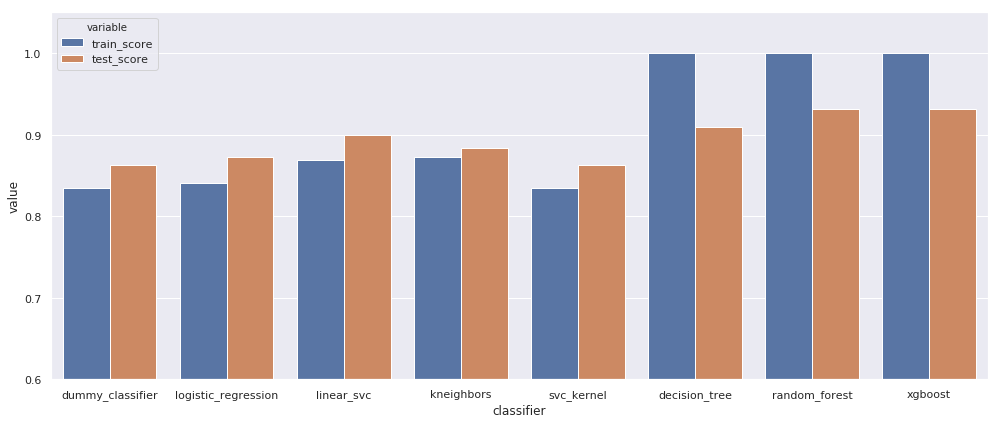

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (14,6))
sns.barplot(x='classifier', y='value', hue='variable', data=df_scores_melted)
ax.set(ylim=[0.6,1.05])
plt.tight_layout()

From these results, it is clear that almost all the models exceed the dummy classifier in the training set although the logistic regression and the SVC with the RBF kernel get more or less the same accuracy.

Notice how the decision tree, the random forest and the xgboost fit the training data perfectly, however, in the test set it is not like this. It is due to these models are capable of fitting complex datasets very well and learn complex decision boundaries, but when it comes to predicting from values never seen before the accuracy drops.

We are interested in predicting from data that the model has not seen before. So **to choose the best models we only look at the test_score.** The best models according to that are:
* Random forest
* XGBoost

## 5. TRAINING AND TESTING DIFFERENT ESTIMATORS

In this section, we will train different estimators. In order to see how the performance of the classifiers increase when we adjust each  model specifically we are going to follow the next steps and compute the score after each one:

1. Test the classifier with the default parameters.
2. Preprocess the data if the classifier needed it.
3. Tune the parameters.

To test the classifiers we will use the **ROC_AUC** score that can be interpreted as the probability that the classifier will assign a higher score to a randomly chosen positive example than to a randomly chosen negative example.



In [12]:
# initializing a list to store the scores of the different classifiers
l_score =[]

### KNeighbors Classifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


# Default parameters
knn = KNeighborsClassifier()
score_knn = cross_val_score(knn, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_knn))

# With preprocessing
knn_2 = KNeighborsClassifier()
knn_2_pipe = make_pipeline(StandardScaler(), knn_2)
score_knn_2 = cross_val_score(knn_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_knn_2))

# Tuning parameters (with preprocessing)
knn_3 = KNeighborsClassifier()
pipe = Pipeline([('scale',StandardScaler()),('clf',knn_3)])
k_range = range(1,51)
weight_options = ['uniform','distance']
param_grid = dict(clf__n_neighbors = k_range, clf__weights = weight_options)
grid_1 = GridSearchCV(pipe, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_1.fit(X,y)
l_score.append(grid_1.best_score_)
print('Tuning parameters (with preprocessing), ROC_AUC score: {}'.format(grid_1.best_score_))
print('Best parameters {}'.format(grid_1.best_params_))


Default parameters, ROC_AUC score: 0.829642781986532
With preprocessing, ROC_AUC score: 0.8560818377224628
Tuning parameters (with preprocessing), ROC_AUC score: 0.9331720586389413
Best parameters {'clf__weights': 'uniform', 'clf__n_neighbors': 47}


### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

# Default parameters
logreg = LogisticRegression() 
score_logreg = cross_val_score(logreg, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_logreg))

# With preprocessing
logreg_2 = LogisticRegression()
logreg_2_pipe = make_pipeline(StandardScaler(), logreg_2)
score_logreg_2 = cross_val_score(logreg_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_logreg_2))

# Tuning parameters (with preprocessing)
logreg_3 = LogisticRegression()
pipe = Pipeline([('scale',StandardScaler()),('clf',logreg_3)])
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(clf__C = C_range, )
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid.fit(X,y)
print('Tuning parameters (with preprocessing), ROC_AUC score: {}'.format(grid.best_score_))
print('Best parameter {}'.format(grid.best_params_))


# Tuning parameters (without preprocessing)
logreg_4 = LogisticRegression()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_2 = GridSearchCV(logreg_4, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_2.fit(X,y)
l_score.append(grid_2.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_2.best_score_))
print('Best parameter {}'.format(grid_2.best_params_))



Default parameters, ROC_AUC score: 0.923297897126022
With preprocessing, ROC_AUC score: 0.9183494167869167
Tuning parameters (with preprocessing), ROC_AUC score: 0.9181598521737965
Best parameter {'clf__C': 1}
Tuning parameters (without preprocessing), ROC_AUC score: 0.9236332388100317
Best parameter {'C': 10}


### Linear Support Vector Classification

In [15]:
from sklearn.svm import LinearSVC

# Default parameters
lsvc = LinearSVC() 
score_lsvc = cross_val_score(lsvc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_lsvc))

# With preprocessing
lsvc_2 = LinearSVC()
lsvc_2_pipe = make_pipeline(StandardScaler(), lsvc_2)
score_lsvc_2 = cross_val_score(lsvc_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_lsvc_2))

# Tuning parameters (without preprocessing)
lsvc_3 = LinearSVC()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_3 = GridSearchCV(lsvc_3, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_3.fit(X,y)
l_score.append(grid_3.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_3.best_score_))
print('Best parameter {}'.format(grid_3.best_params_))


Default parameters, ROC_AUC score: 0.9218889039201539
With preprocessing, ROC_AUC score: 0.9083553165584416
Tuning parameters (without preprocessing), ROC_AUC score: 0.9226824663826656
Best parameter {'C': 0.1}


### Support Vector Classification

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


# Default parameters
svcc = SVC()
score_svcc = cross_val_score(svcc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_svcc))

# With preprocessing
svcc_2 = SVC()
svcc_2_pipe = make_pipeline(MinMaxScaler(), svcc_2)
score_svcc_2 = cross_val_score(svcc_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_svcc_2))

# Tuning parameters (without preprocessing)
svcc_3 = SVC()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_4 = GridSearchCV(svcc_3, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_4.fit(X,y)
l_score.append(grid_4.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_4.best_score_))
print('Best parameter {}'.format(grid_4.best_params_))



Default parameters, ROC_AUC score: 0.9190634018759019
With preprocessing, ROC_AUC score: 0.9018116432178932
Tuning parameters (without preprocessing), ROC_AUC score: 0.9191570658204125
Best parameter {'C': 0.01}


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Default parameters
rfc = RandomForestClassifier()
score_rfc = cross_val_score(rfc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_rfc))

# Tuning parameters (without preprocessing)
rfc_2 = RandomForestClassifier()
n_range = range(10,101,10)
param_grid = dict(n_estimators = n_range)
grid_5 = GridSearchCV(rfc_2, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_5.fit(X,y)
l_score.append(grid_5.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_5.best_score_))
print('Best parameter {}'.format(grid_5.best_params_))



Default parameters, ROC_AUC score: 0.8808301579785954
Tuning parameters (without preprocessing), ROC_AUC score: 0.9101009681811475
Best parameter {'n_estimators': 70}


### Gradient Boosted Decision Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Default parameters
gbc = GradientBoostingClassifier()
score_gbc = cross_val_score(gbc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_rfc))

# Tuning parameters (without preprocessing)
gbc_2 = RandomForestClassifier()
n_range = range(10,101,10)
param_grid = dict(n_estimators = n_range)
grid_6 = GridSearchCV(gbc_2, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_6.fit(X,y)
l_score.append(grid_6.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_6.best_score_))
print('Best parameter {}'.format(grid_6.best_params_))

Default parameters, ROC_AUC score: 0.8808301579785954
Tuning parameters (without preprocessing), ROC_AUC score: 0.9145100095050297
Best parameter {'n_estimators': 90}


## 6. CHOOSING THE BEST ESTIMATOR

We have tested all the classifiers and we know the score for each of them. Clearly, the best performance has been obtained tuning the parameters with a GridSearchCV. Now for each classifier, we are going to compute the execution time to add it as a new criterion when choosing the best estimator.

In [19]:
import time

grids = [grid_1, grid_2, grid_3, grid_4, grid_5, grid_6]
l_time = []
for estimator in grids:
    est_t = []
    for rep in range(10): # we do 10 simulations for each estimator
        start = time.time()
        estimator.predict(X_predict) 
        end = time.time()
        est_t.append(end-start)  
    l_time.append(np.asarray(est_t).mean())

We store the scores and execution times in a data frame:

In [20]:
l_estim = ['KNeighbours','Logit', 'LSVC','SVC','Random Forest','GB']
df_est = pd.DataFrame({'Estimator': l_estim, 'Score': l_score, 'Execution time [s]': l_time})
df_est

,Estimator,Execution time [s],Score
0,KNeighbours,0.003375,0.933172
1,Logit,0.000360,0.923633
2,LSVC,0.000420,0.922682
3,SVC,0.001293,0.919157
4,Random Forest,0.006255,0.910101
5,GB,0.007215,0.914510


To see graphically the performance of each classifier, we will do a scatter plot. In the x-axis we have the score and in the y-axis we have the execution time:

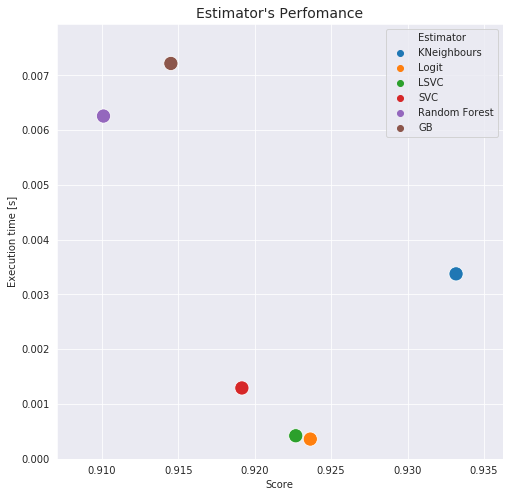

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
g = sns.scatterplot(data = df_est, y = 'Execution time [s]', x = 'Score', s = 200, hue = 'Estimator')
plt.ylim(0, df_est['Execution time [s]'].max() *1.1)
plt.title("Estimator's Perfomance", fontsize = 14)
plt.show()

From the scatter plot we can see how the highest score is got from the KNeighbours Classifier and the lowest from the Random Forest. In terms of execution time, we can differentiate two groups, the one composed by the the Gradient Boosted Decision Trees and the Random Forest and the other composed by the SVC, the LSVC and the Logistic Regression, this last group is much faster converging to the solution. Between both groups is the KNeighbours classifier.

## 7. CONCLUSION

Under the assumption that for our task the time is not a limiting resource, we choose as the best classifier the **KNeighbours Classifier**. We have achieved to create an algorithm that predicts if a employee has a management job postion in a company from the email network of that company.

Finally, we proceed to compute the probabilities of the classifier giving a positive value to the target. With this information we can set a threshold to increase the sensitivity of our classifier and be more confident with the final conclusion. We set the threshold in the 80%:

In [22]:
X_predict['Probability'] = grid_1.predict_proba(X_predict)[:,1]
prob = X_predict.index[X_predict['Probability'] > 0.8].tolist()
print('Employees {} are receiving a management position salary with a higher probability of 80%.'.
      format(prob))

Employees [5, 62, 65, 142, 249, 283, 420, 434, 533, 820] are receiving a management position salary with a higher probability of 80%.
